# 第五节 Stable Diffusion

## 你将学到什么？  
1、Stable Diffusion管线
2、
3、

## 5.1 运用 Stable Diffusion 从文本生成图像的示例

In [2]:
import os
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
# 这次要探索的管线比较多
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
)

# 网络不好，可能需要多尝试几次下载
# 一个下载异常重试的装饰器，对于需要下载的模块避免重复写下载异常判断
import functools

def retry_on_exception(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        while True:
            try:
                return func(*args, **kwargs)
            except Exception as e:
                print(e)
    return wrapper

# 因为要用到的展示图片较多，所以我们写了一个下载图片的函数
@retry_on_exception
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")
# Inpainting需要用到的图片
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

# 模型数据存放路径，默认放在同一个文件夹
model_zoo_dir = r'E:\model_zoo\huggingface\diffusers'

### 5.1.1 载入Stable Diffusion管线  
示例载入的模型版本是stable-diffusion-2-1-base，可自行去Hugging Face查找想用的版本替换model_id 

In [3]:
model_id = "stabilityai/stable-diffusion-2-1-base"
cache_dir = os.path.join(model_zoo_dir, 'stable-diffusion-2-1-base')
# 如果显存不足请指定revision="fp16",torch_dtype=torch.float16
@retry_on_exception
def load_stable_diffusion_pipeline(model_id, cache_dir, torch_dtype=torch.float32, device='cuda'):
    return StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch_dtype, cache_dir=cache_dir).to(device)

pipe = load_stable_diffusion_pipeline(model_id, cache_dir, device=device)

HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /stabilityai/stable-diffusion-2-1-base/resolve/main/model_index.json (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1007)')))


E:\ProgramData\Anaconda3\envs\test\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in E:\model_zoo\huggingface\diffusers\stable-diffusion-2-1-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vae\diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Max retries exceeded with url: /repos/24/cb/24cbc2f7542236eb613b4f16b6802d7c2bef443e86cf9d076719733866e66c3a/a434f8fdbb51f080ac57a4377281241467c4efc1417b27646ffae989644de60c?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27diffusion_pytorch_model.bin%3B+filename%3D%22diffusion_pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1693185162&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MzE4NTE2Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8yNC9jYi8yNGNiYzJmNzU0MjIzNmViNjEzYjRmMTZiNjgwMmQ3YzJiZWY0NDNlODZjZjlkMDc2NzE5NzMzODY2ZTY2YzNhL2E0MzRmOGZkYmI1MWYwODBhYzU3YTQzNzcyODEyNDE0NjdjNGVmYzE0MTdiMjc2NDZmZmFlOTg5NjQ0ZGU2MGM~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=cz99odBOFc6jJDmiEFQCu0uiX0l7k-QELV3EesO0T4sCGBCDIdowQUnrjXb8FxlAqNin-xUVBFr~ZXBrsGj7TMaS0ROmVhSTcVryE4TtHgtJZ

vae\diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Max retries exceeded with url: /repos/24/cb/24cbc2f7542236eb613b4f16b6802d7c2bef443e86cf9d076719733866e66c3a/a434f8fdbb51f080ac57a4377281241467c4efc1417b27646ffae989644de60c?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27diffusion_pytorch_model.bin%3B+filename%3D%22diffusion_pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1693181432&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MzE4MTQzMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8yNC9jYi8yNGNiYzJmNzU0MjIzNmViNjEzYjRmMTZiNjgwMmQ3YzJiZWY0NDNlODZjZjlkMDc2NzE5NzMzODY2ZTY2YzNhL2E0MzRmOGZkYmI1MWYwODBhYzU3YTQzNzcyODEyNDE0NjdjNGVmYzE0MTdiMjc2NDZmZmFlOTg5NjQ0ZGU2MGM~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=w8kks5tUq~a91hguKFTbBrl2NFusOzMwX7mTaWfp9lVC96cHMZk~Ojc-6vADfvbfwUniRMF55HFUwKkI6ON9yEjA7jag80FQP4EOj3eItZaF1

vae\diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Max retries exceeded with url: /repos/24/cb/24cbc2f7542236eb613b4f16b6802d7c2bef443e86cf9d076719733866e66c3a/a434f8fdbb51f080ac57a4377281241467c4efc1417b27646ffae989644de60c?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27diffusion_pytorch_model.bin%3B+filename%3D%22diffusion_pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1693185191&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MzE4NTE5MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8yNC9jYi8yNGNiYzJmNzU0MjIzNmViNjEzYjRmMTZiNjgwMmQ3YzJiZWY0NDNlODZjZjlkMDc2NzE5NzMzODY2ZTY2YzNhL2E0MzRmOGZkYmI1MWYwODBhYzU3YTQzNzcyODEyNDE0NjdjNGVmYzE0MTdiMjc2NDZmZmFlOTg5NjQ0ZGU2MGM~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=j6uppmyL5mue9deipotF8x7M0VRyFgOnbbNIlhmLyjcdCurzOYPyl0LJxA-fzcdyoKQM9Gqp8B3qqgAHoEajtLMV6TpownMDKtOmghLjxtbYC

vae\diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Max retries exceeded with url: /repos/24/cb/24cbc2f7542236eb613b4f16b6802d7c2bef443e86cf9d076719733866e66c3a/a434f8fdbb51f080ac57a4377281241467c4efc1417b27646ffae989644de60c?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27diffusion_pytorch_model.bin%3B+filename%3D%22diffusion_pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1693185162&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5MzE4NTE2Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy8yNC9jYi8yNGNiYzJmNzU0MjIzNmViNjEzYjRmMTZiNjgwMmQ3YzJiZWY0NDNlODZjZjlkMDc2NzE5NzMzODY2ZTY2YzNhL2E0MzRmOGZkYmI1MWYwODBhYzU3YTQzNzcyODEyNDE0NjdjNGVmYzE0MTdiMjc2NDZmZmFlOTg5NjQ0ZGU2MGM~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=cz99odBOFc6jJDmiEFQCu0uiX0l7k-QELV3EesO0T4sCGBCDIdowQUnrjXb8FxlAqNin-xUVBFr~ZXBrsGj7TMaS0ROmVhSTcVryE4TtHgtJZ

vae\diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

注意力切分功能，降低速度减少GPU占用（可选）

In [ ]:
# pipe.enable_attention_slicing()

### 5.1.2 Stable Diffusion文生图  
主要的调节参数如下：  
● width和height用于指定所生成图片的尺寸，注意它们必须是能被8整除的数字，因为只有这样，VAE才能正常工作（原因稍后介绍）。  
● 步数num_inference_steps也会影响所生成图片的质量，采用默认设置50即可，你也可以尝试将其设置为20并观察效果。  
● negative_prompt用于强调不希望生成的内容，这个参数一般在无分类器引导的情况下使用。这种添加额外控制的方式特别有效：列出一些不想要的特征，以帮助生成更好的结果。  
● guidance_scale 决定了无分类器引导的影响强度。增大这个参数可以使生成的内容更接近给出的文本提示语；但如果该参数过大，则可能导致结果过于饱和，不美观。

  0%|          | 0/50 [00:00<?, ?it/s]

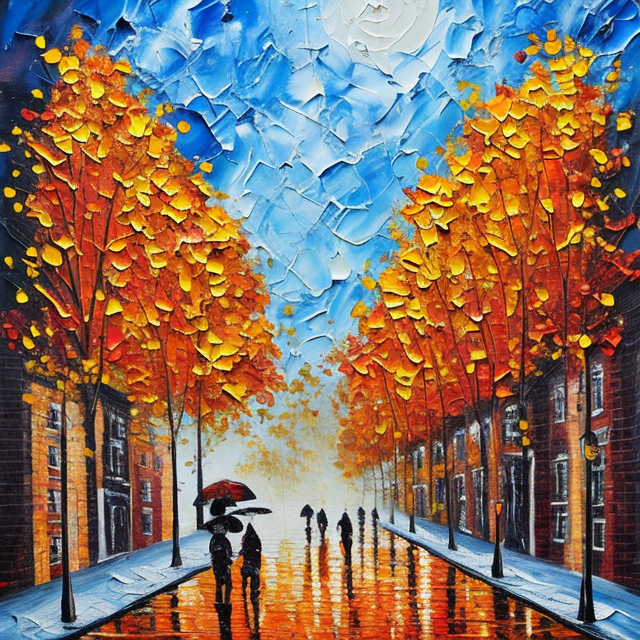

In [4]:
# 给生成器设置一个随机种子，这样可以保证结果的可复现性
generator = torch.Generator(device=device).manual_seed(42)
# 运行这个管线
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape",
    # 提示文字：哪些要生成
    negative_prompt="Oversaturated, blurry, low quality",
    # 提示文字：哪些不要生成
    height=640, width=640,     # 定义所生成图片的尺寸
    guidance_scale=8,          # 提示文字的影响程度
    num_inference_steps=50,    # 定义一次生成需要多少个推理步骤
    generator=generator        # 设定随机种子的生成器
)
# 查看生成结果
pipe_output.images[0]

逐渐增大guidance_scale观察效果。  
一般来说这种影响给人的感受是非常主观的，但总体来说，设置guidance_scale在8-12是不错的选择  

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

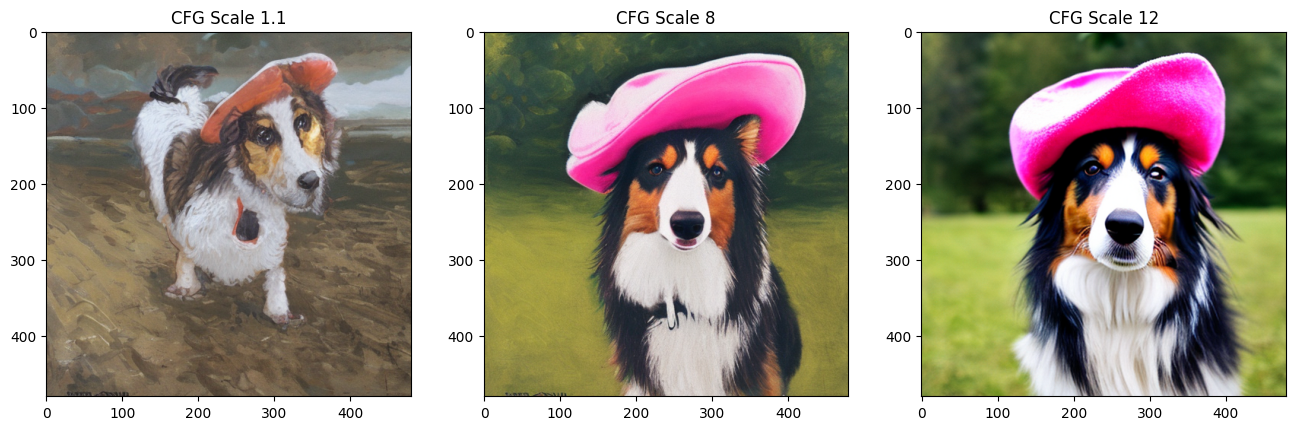

In [5]:
cfg_scales = [1.1, 8, 12] 
prompt = "A collie with a pink hat" 
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(prompt, height=480, width=480, 
              guidance_scale=cfg_scales[i], num_inference_steps=35, 
              generator=torch.Generator(device=device).manual_seed(42)).images[0] 
    ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}')

## 5.2 Stable Diffusion管线探索

首先打印管线的组件，观察组成：

In [6]:
print(list(pipe.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


vae：可变分自编码器  
text_encoder：文本编码器    
tokenizer：分词器  
unet：unet网络结构的去噪模型  
scheduler：调度器  
safety_checker：安全检查模型  
feature_extractor：特征提取器  
下面我们将挑选核心组件进行讲解和演示。

### 5.2.1 VAE  
![vae](../images/vae.jpg)
可变分自编码器（VAE）是一种模型，它的结构如上图所示。  
VAE可以对输入图像进行编码，得到“压缩过”的信息，之后再解码“隐式的”压缩信息，得到接近输入的输出。  
在使用Stable Diffusion生成图片时，我们首先需要在VAE的“隐空间”（latent space）中应用扩散过程以生成隐编码，然后在结尾对它们进行解码，得到最终的输出。  
因此，去噪UNet模型的输入不是完整的图片（区别于前面的DDPM），而是缩小版的特征，这样可以极大地减少对计算资源的使用。

In [7]:
# 创建取值区间为(-1, 1)的伪数据
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)
# 编码到隐空间
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)
# 再解码回来
with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


### 5.2.2 分词器和文本编码器

In [8]:
# 手动对提示文字进行分词和编码
# 分词
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")
# 将分词结果输入CLIP（管线使用CLIP的文本编码器） 
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
    print("Text embeddings shape:", text_embeddings.shape)

# 输出最终编码结果
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, False, '')
print(text_embeddings.size())

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])
torch.Size([1, 77, 1024])


### 5.2.3 UNet  
![hidden_state_unet](../images/hidden_state_unet.jpg)

In [9]:
# 创建伪输入
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)
# 让模型进行预测
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape)

UNet output shape: torch.Size([1, 4, 64, 64])


### 5.2.4 调度器  
调度器保存了关于如何添加噪声的信息，并管理如何基于模型的预测更新“带噪”样本。  
默认调度器是 PNDMScheduler，也可以使用其他调度器如 LMSDiscreteScheduler

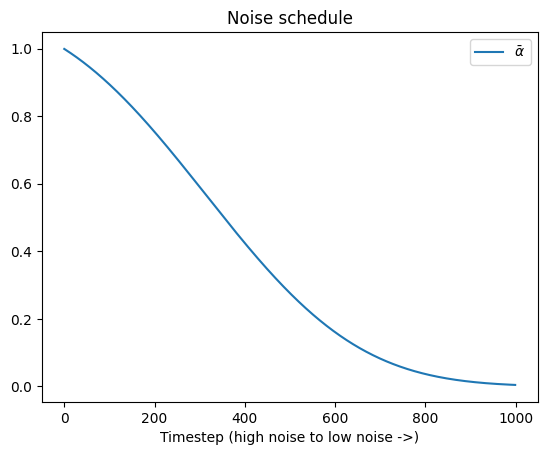

In [10]:
# 观察采样过程中噪声的变化
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)')
plt.title('Noise schedule')
plt.legend()

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.16.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}



  0%|          | 0/50 [00:00<?, ?it/s]

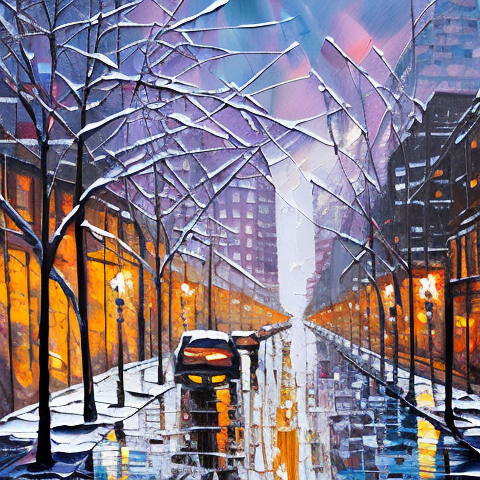

In [11]:
from diffusers import LMSDiscreteScheduler
# 替换原来的调度器
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
# 输出配置参数
print('Scheduler config:', pipe.scheduler)
# 使用新的调度器生成图片
pipe(prompt="Palette knife painting of an winter cityscape", 
     height=480, width=480, generator=torch.Generator(device=device).manual_seed(42)).images[0]

### 5.2.5 自定义采样循环 

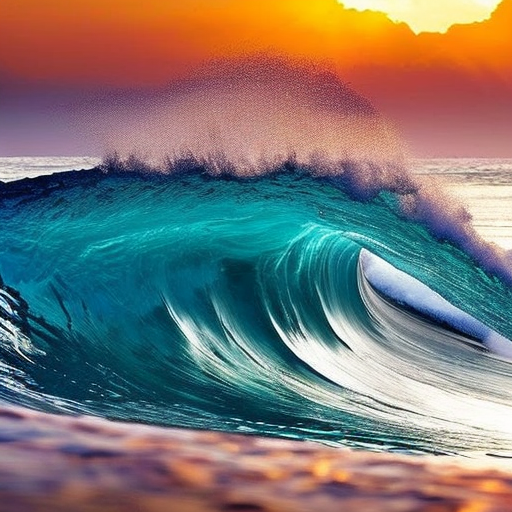

In [45]:
guidance_scale = 8
num_inference_steps=30
prompt = "Beautiful picture of a wave breaking"
negative_prompt = "zoomed in, blurry, oversaturated, warped"

# 对提示文字进行编码
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)
text_embeddings_none = pipe._encode_prompt("", device, 1, True, "")
# 创建随机噪声作为起点
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
# 调度器需要使用初始噪声分布 sigma（噪声比例值）缩放输入
# 这是 UniPCMultistepScheduler 等改进调度器所需的
# 参见官方文档https://huggingface.co/docs/diffusers/main/en/using-diffusers/write_own_pipeline和"UniPC: A Unified Predictor-Corrector Framework for Fast Sampling of Diffusion Models"
latents *= pipe.scheduler.init_noise_sigma
# 准备调度器
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
# 生成过程开始

for i, t in enumerate(pipe.scheduler.timesteps):
    # 这里使用无分类器引导技巧
    # 对于无分类器引导（Classifier-Free Guidance，CFG），我们需要进行两次预测（前向）：一个没有文字条件，另一个则有文字条件
    # 对输入的隐变量*2是为了避免进行两次前向，我们通过一次前向把它们都预测出来
    latent_model_input = torch.cat([latents] * 2)
    # 添加噪声
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # 把预测的噪声分为无引导和有引导两种
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        # 用 guidance_scale 控制引导强弱（文字控制的力度）
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    # 计算前一步的采样噪声 x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# 将隐变量映射到图片
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

pipe.numpy_to_pil(image)[0]

In [41]:
# 其他pipeline介绍